In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from scipy.stats import bernoulli

from matplotlib.ticker import FormatStrFormatter

In [2]:
np.random.seed(0)
scaler = StandardScaler()

### Conjunto de datos: SDSS DR17

In [3]:
url = "https://raw.githubusercontent.com/igomezv/nnogada/main/data/star_classification.csv"
data = pd.read_csv(url)
cols = ['alpha','delta','u','g','r','i','z','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY


Se cambian las clases a vectores con números enteros

$$ \text{GALAXY}: \begin{pmatrix}1\\0\\0\end{pmatrix},\quad \text{STAR}: \begin{pmatrix}0\\1\\0\end{pmatrix},\quad \text{QSO}:\begin{pmatrix}0\\0\\1\end{pmatrix} $$

In [4]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   class  
0      0  
1      0  
2      0  
3      0  
4      0  


In [5]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:7]
    Y = data[:,7]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [6]:
# Split dataset into train, validation and test sets
X,Y = prepare_dataset(data)

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_, X_test, y_, Y_test = split(X, Y, test_size = ratio_test, random_state=0)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, Y_train, Y_val = split(x_, y_, test_size=ratio_val_adjusted, random_state=0)

# Normalize and scale the input sets.
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

### Arquitectura del modelo proveniente de la malla de hiperparámetros

In [45]:
t = time.time(); t_total = 0    
deep_layers = 3
num_units = 100
learning_rate = 1e-3
batch_size = 128
epochs = 50

my_callbacks = [tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=50,
                               verbose=1,
                               restore_best_weights=True)]
    

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
model1.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    model1.add(Dense(num_units, activation='relu'))
model1.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
train1 = model1.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=batch_size, shuffle=1, verbose=1)
    
loss1, score1 = model1.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", score1, ", Elapsed time:", t)

Epoch 1/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6475 - accuracy: 0.7425 - val_loss: 0.5472 - val_accuracy: 0.7877
Epoch 2/50
625/625 [==============================] - 1s 1ms/step - loss: 0.5206 - accuracy: 0.8023 - val_loss: 0.5096 - val_accuracy: 0.8034
Epoch 3/50
625/625 [==============================] - 1s 1ms/step - loss: 0.4868 - accuracy: 0.8168 - val_loss: 0.4571 - val_accuracy: 0.8274
Epoch 4/50
625/625 [==============================] - 1s 1ms/step - loss: 0.4639 - accuracy: 0.8306 - val_loss: 0.4339 - val_accuracy: 0.8387
Epoch 5/50
625/625 [==============================] - 1s 1ms/step - loss: 0.4274 - accuracy: 0.8431 - val_loss: 0.4087 - val_accuracy: 0.8483
Epoch 6/50
625/625 [==============================] - 1s 1ms/step - loss: 0.4081 - accuracy: 0.8500 - val_loss: 0.3908 - val_accuracy: 0.8575
Epoch 7/50
625/625 [==============================] - 1s 1ms/step - loss: 0.3984 - accuracy: 0.8551 - val_loss: 0.3870 - val_accuracy: 0.8581
Epoch 

In [46]:
def plot_cm(Y_test, Y_pred, labels, porcentaje=False, cbar=False, ax=None):
    matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred)   
    #Aquí se divide si queremos en porcentaje o números
    if porcentaje==False: 
        ax = sns.heatmap(matrix, annot=True, cmap="OrRd", cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    if porcentaje==True:
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])*100
            
        ax = sns.heatmap(m, annot=True,cmap='OrRd', cbar=cbar, cbar_kws={'label': 'scale'}, ax=ax)
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    # ax.set(xlabel="True label", ylabel="Predicted label")

    return ax

313/313 [==============================] - 0s 568us/step


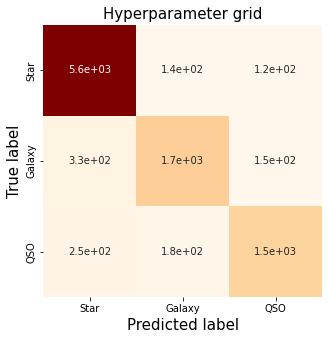

In [54]:
X_test_inverse = scaler.inverse_transform(X_test)
labels=['Star','Galaxy','QSO']
porcentaje = True

# titles.append(f"Confusion matrix model")
# plot_cm(Y_test, model1.predict(X_test), labels, porcentaje=porcentaje)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

y_pred = model1.predict(X_test)
y_test=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred, axis=1)
plot_cm(Y_test, y_pred, labels=labels, porcentaje=False, ax=ax)
plt.title("Hyperparameter grid", fontsize=15)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.savefig("classification_grid_cm.png")

0.30414897203445435

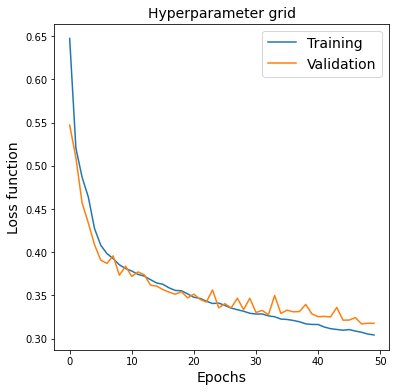

In [48]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(train1.history['loss'], label='Training')
plt.plot(train1.history['val_loss'], label='Validation')
# plt.ylim(0.25, 0.65)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title("Hyperparameter grid", fontsize=14)
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.savefig("classification_grid_loss.png")
np.min(train1.history['loss'])

In [49]:
model1.save("models/classification_grid.h5")

In [50]:
print("epochs", len(train1.history['loss']))

epochs 50


In [51]:
# other metrics
am = accuracy_score(y_test, y_pred)
pm = precision_score(y_test, y_pred, average='weighted')
# rm = roc_auc_score(y_test, y_pred,multi_class='ovr')
fm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", am)
print("Precision:", pm)
print("F1:", fm)

Accuracy: 0.8836
Precision: 0.8816140713221906
F1: 0.8816617391024034


### Arquitectura del modelo proveniente del algoritmo genéticos (mismo número de evaluaciones que con la malla)

In [52]:
t = time.time(); t_total = 0    
deep_layers = 3
num_units = 200
learning_rate = 0.001
batch_size = 256


modela = tf.keras.Sequential()
modela.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
modela.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    modela.add(Dense(num_units, activation='relu'))
modela.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
modela.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
traina = modela.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=batch_size, shuffle=1, verbose=1)
    
lossa, scorea = modela.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", scorea, ", Elapsed time:", t)

Epoch 1/50
313/313 [==============================] - 1s 3ms/step - loss: 0.7020 - accuracy: 0.7153 - val_loss: 0.5443 - val_accuracy: 0.7895
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 0.5345 - accuracy: 0.7974 - val_loss: 0.5271 - val_accuracy: 0.7979
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.5089 - accuracy: 0.8077 - val_loss: 0.5145 - val_accuracy: 0.8010
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4886 - accuracy: 0.8184 - val_loss: 0.4649 - val_accuracy: 0.8240
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.4646 - accuracy: 0.8290 - val_loss: 0.4438 - val_accuracy: 0.8377
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.8399 - val_loss: 0.4247 - val_accuracy: 0.8414
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4114 - accuracy: 0.8504 - val_loss: 0.3992 - val_accuracy: 0.8528
Epoch 

In [15]:
t = time.time(); t_total = 0    
deep_layers = 4
num_units = 200
learning_rate = 1e-3
batch_size = 256
    

modelb = tf.keras.Sequential()
modelb.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
modelb.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    modelb.add(Dense(num_units, activation='relu'))
modelb.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
modelb.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
trainb = modelb.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=batch_size, shuffle=1, verbose=1)
    
lossb, scoreb = modelb.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", scoreb, ", Elapsed time:", t)

Epoch 1/50
313/313 [==============================] - 1s 3ms/step - loss: 0.6900 - accuracy: 0.7159 - val_loss: 0.5356 - val_accuracy: 0.7921
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 0.5300 - accuracy: 0.7984 - val_loss: 0.5150 - val_accuracy: 0.8004
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.5033 - accuracy: 0.8083 - val_loss: 0.4774 - val_accuracy: 0.8171
Epoch 4/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4721 - accuracy: 0.8242 - val_loss: 0.4518 - val_accuracy: 0.8297
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4368 - accuracy: 0.8398 - val_loss: 0.4155 - val_accuracy: 0.8489
Epoch 6/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4384 - accuracy: 0.8469 - val_loss: 0.4196 - val_accuracy: 0.8519
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 0.4101 - accuracy: 0.8512 - val_loss: 0.3919 - val_accuracy: 0.8556
Epoch 

In [16]:
t = time.time(); t_total = 0    
deep_layers = 3
num_units = 200
learning_rate = 1e-3
batch_size = 128
    

modelc = tf.keras.Sequential()
modelc.add(tf.keras.layers.InputLayer(int(X_train.shape[1],)))
modelc.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
for i in range(deep_layers):        
    modelc.add(Dense(num_units, activation='relu'))
modelc.add(Dense(3, activation=tf.nn.softmax))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
modelc.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
trainc = modelc.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
                    callbacks=my_callbacks, batch_size=batch_size, shuffle=1, verbose=1)
    
lossc, scorec = modelc.evaluate(X_val, Y_val)    
t = time.time()-t
print("Accuracy:", scorec, ", Elapsed time:", t)

Epoch 1/50
625/625 [==============================] - 2s 2ms/step - loss: 0.6314 - accuracy: 0.7510 - val_loss: 0.5284 - val_accuracy: 0.7972
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.5339 - accuracy: 0.8076 - val_loss: 0.4732 - val_accuracy: 0.8232
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4736 - accuracy: 0.8241 - val_loss: 0.4641 - val_accuracy: 0.8217
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4458 - accuracy: 0.8373 - val_loss: 0.4265 - val_accuracy: 0.8426
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.4134 - accuracy: 0.8476 - val_loss: 0.4141 - val_accuracy: 0.8482
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3983 - accuracy: 0.8537 - val_loss: 0.3762 - val_accuracy: 0.8630
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.3905 - accuracy: 0.8578 - val_loss: 0.3740 - val_accuracy: 0.8645
Epoch 

313/313 [==============================] - 0s 624us/step
Accuracy: 0.8865
Precision: 0.8858837990990646
F1: 0.8858325878884318


(0.30414897203445435,
 0.30665507912635803,
 0.2986975312232971,
 0.289667546749115)

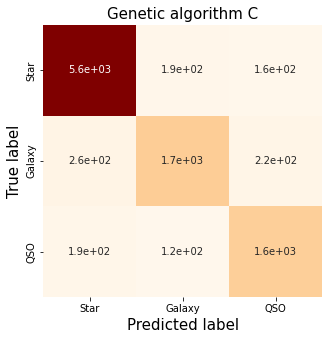

In [53]:
model = modela
X_test_inverse = scaler.inverse_transform(X_test)
labels=['Star','Galaxy','QSO']
porcentaje = True

# titles.append(f"Confusion matrix model")
# plot_cm(Y_test, model1.predict(X_test), labels, porcentaje=porcentaje)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

y_pred = model.predict(X_test)
y_test=np.argmax(Y_test, axis=1)
y_pred=np.argmax(y_pred, axis=1)
plot_cm(Y_test, y_pred, labels=labels, porcentaje=False, ax=ax)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.title("Genetic algorithm C", fontsize=15)
plt.savefig("classification_genetic_cm.png")

# other metrics
am = accuracy_score(y_test, y_pred)
pm = precision_score(y_test, y_pred, average='weighted')
# rm = roc_auc_score(y_test, y_pred,multi_class='ovr')
fm = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", am)
print("Precision:", pm)
print("F1:", fm)
np.min(train1.history['loss']), np.min(traina.history['loss']), np.min(trainb.history['loss']), np.min(trainc.history['loss'])

0.30717769265174866

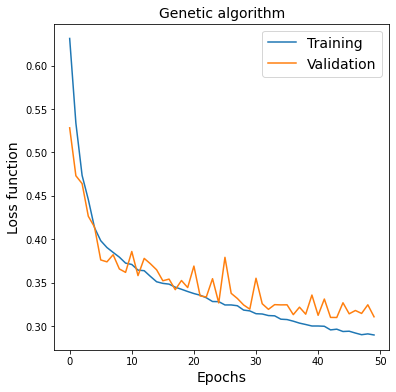

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(trainc.history['loss'], label='Training')
plt.plot(trainc.history['val_loss'], label='Validation')
# plt.ylim(0.25, 0.65)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.title("Genetic algorithm", fontsize=14)
plt.savefig("classification_genetic_loss.png")
np.min(train1.history['loss'])

In [19]:
modelc.save("models/classification_genetic.h5")

In [20]:
print("epochs", len(trainc.history['loss']))

epochs 50


0.30414897203445435

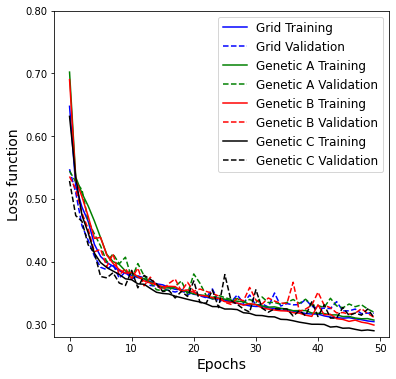

In [55]:
# All loss

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(train1.history['loss'], label='Grid Training', color='blue')
plt.plot(train1.history['val_loss'], label='Grid Validation', color='blue', linestyle='dashed')
plt.plot(traina.history['loss'], label='Genetic A Training', color='green')
plt.plot(traina.history['val_loss'], label='Genetic A Validation', color='green', linestyle='dashed')
plt.plot(trainb.history['loss'], label='Genetic B Training', color='red')
plt.plot(trainb.history['val_loss'], label='Genetic B Validation', color='red', linestyle='dashed')
plt.plot(trainc.history['loss'], label='Genetic C Training', color='black')
plt.plot(trainc.history['val_loss'], label='Genetic C Validation', color='black', linestyle='dashed')
plt.ylim(0.28, 0.8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('Loss function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
# plt.title("Genetic algorithm", fontsize=14)
plt.savefig("classification_loss.png")
np.min(train1.history['loss'])